# MNIST classification with a continous time-RBF NN

In this little test, I'll use the classic MNIST hand-written numbers data set to try out a classification scheme based on the continuous-time dynamical system I'm working on for my dissertation (see, e.g., Smith & Tabor, submitted). The model is based on those presented in Han et al. (1989), Ciocoiu (1996, 2009), and Muezzinoglu & Zurada (2006). The idea is to create an RBF-based energy landscape with energy minima (or harmony maxima, Smolensky, 1986) for each pattern you want to store. You then just initialize the state of the system with a test pattern, and it settles to the nearest exemplar.

Here, I'll take the very simple approach of making the centers of the RBFs be a the averages of each target number in the training set. This seems to be a simplification of what Ciocoiu (2009) did. Let $\mathbf{x}$ be the state of the system and $\mathbf{c}_i$ be the location of the $i$th stored pattern. Both are in $\mathbb{R}^{64}$. The harmony landscape is defined as
$$
H(\mathbf{x}) = \sum_{i = 0}^9 \phi_i(\mathbf{x})
$$
with
$$
\phi_i(\mathbf{x}) = \exp\left( -\gamma^{-1} (\mathbf{x} - \mathbf{c}_i)^\intercal (\mathbf{x} - \mathbf{c}_i)\right)
$$
where $\gamma$ sets the widths of the RBFs. The classification dynamics are given by the coupled ordinary differential equations
$$
\dot{\mathbf{x}} = -2\gamma^{-1}\sum_{i = 0}^9 \phi_i(\mathbf{x}) (\mathbf{x} - \mathbf{c}_i)
$$

Now, I'll set this up using NumPy.

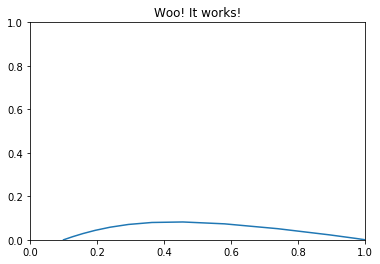

In [112]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Defining phi
def phi(x, c, gamma):
    # This is equivalent to the squared Euclidean distance
    sqdist = np.dot(x - c, x - c)
    return np.exp(-sqdist / gamma)


def step_dyn(x, centers, gamma):
    dx = np.zeros(x.shape)
    for c in range(centers.shape[0]):
        dx += phi(x, centers[c,], gamma) * (x - centers[c,])
    return (-2 / gamma) * dx


def settle_once(xinit, centers, gamma):
    # Quick test
    tau = 0.1  # time step for the discretized Euler-forward dynamics
    tsteps = 50
    xhist = np.zeros((tsteps, len(xinit)))
    xhist[0,] = xinit
    for t in range(tsteps-1):
        xhist[t+1,] = xhist[t,] + tau*step_dyn(xhist[t,], centers, gamma)
    return xhist


centers = np.array([[1, 0], [0, 1]])
gamma = 0.25  # This is a free parameter that will need to be fit
#x = np.zeros((tsteps, 2))
xinit = np.array([0.1, 0.])  # Initial condition

xhist = settle_once(xinit, centers, gamma)

plt.plot(xhist[:, 0], xhist[:, 1])
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title('Woo! It works!')
plt.show()

Now that the basic classifier is working, we can try it out for real. Let's load the data and see how it's organized.

In [113]:
from sklearn import datasets

mnist = datasets.fetch_mldata('MNIST original')  # This took many tries to get to work...
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

Cool. Now, I'll create the training and test data sets. There are 70,000 exemplars, so I'll take the first 60,000 for training.

In [114]:
X = mnist['data']
y = mnist['target']
#print(y[:20])  # looks like they're sorted
ntrain = 60000
ntest = 10000
Xtrain, Xtest, ytrain, ytest = X[:ntrain], X[ntrain:], y[:ntrain], y[ntrain:]
print(Xtrain.shape)
ndim = Xtrain.shape[1]

(60000, 784)


Now, I'll create the centers of the RBFs. There's probably a better way of doing this, but I'll start here because it's simple.

In [115]:
centers = np.zeros((10, ndim))
for i in range(10):
    centers[i,] = np.mean(Xtrain[ytrain == i,:], axis=0)
print(centers.shape)

(10, 784)


Now, just to see what these averages look like:

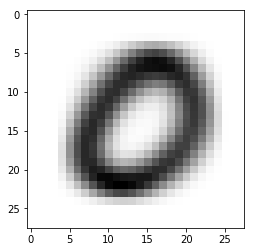

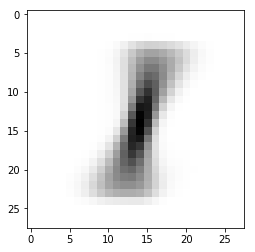

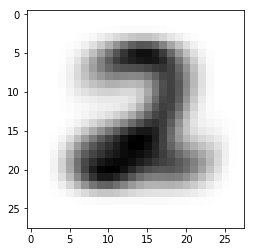

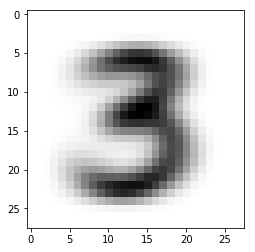

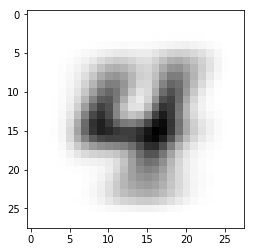

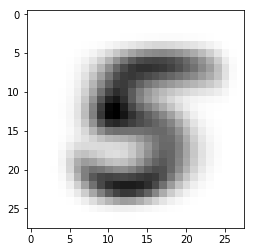

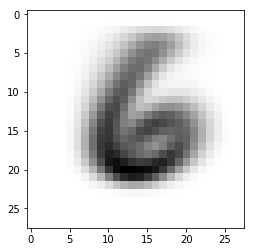

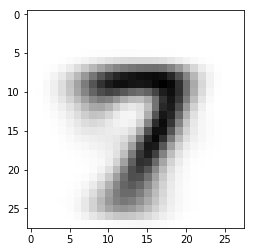

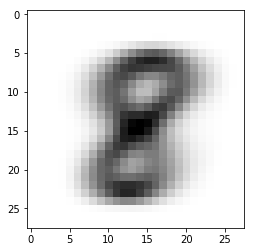

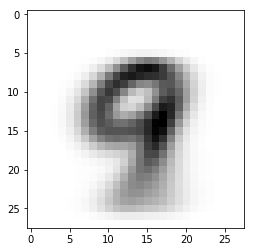

In [116]:
for i in range(10):
    plt.imshow(centers[i,].reshape(28, 28), cmap=matplotlib.cm.binary)
    plt.show()

Yay! The averaging worked! Now we can test it on a single image.

Current test number: 0.0


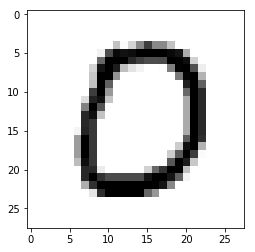

In [117]:
print('Current test number: {}'.format(ytest[0]))
xinit = Xtest[1]
plt.imshow(Xtest[1].reshape(28,28), cmap=matplotlib.cm.binary)
plt.show()
xhist = settle_once(xinit, centers, gamma)

Let's see what it was closest to:

In [118]:
from scipy.spatial.distance import cdist
dists = cdist(centers, xhist[-1,].reshape(1, ndim), 'euclidean')
print(dists)  # in order from 0 to 9
print(int(np.where(dists.flatten() == np.min(dists))[0]))

[[1641.64530641]
 [2546.31335595]
 [2202.54344378]
 [2098.50909139]
 [2387.36741377]
 [2044.9095538 ]
 [2366.96301395]
 [2489.01621431]
 [2222.20623671]
 [2496.43415055]]
0


Cool! Looks like it got closest to correct answer! Now I'll write a function to return the closest pattern to the final state for a pattern. This is a pretty rough way of determining classification accuracy, but I'll try it for now.

In [119]:
def find_closest(xfinal, centers):
    assert len(xfinal.shape) == 2, 'Final state must be 2D'
    dists = cdist(centers, xfinal, 'euclidean')
    return int(np.where(dists.flatten() == np.min(dists))[0])

find_closest(xhist[-1,].reshape(1, ndim), centers)

0

The big evaluation: Now I want to go through all of the test set and get the model's classification accuracy.

In [132]:
import pandas as pd

outputs = []  # For storing the results
print('Starting classification test...\nTrial:')
for i in range(ntest):
    if i % 500 == 0:
        print('[{}] '.format(i), end='')
    currtarg = ytest[i]
    currinit = Xtest[i]
    xhist = settle_once(currinit, centers, gamma)
    closest = find_closest(xhist[-1,].reshape(1, ndim), centers)
    if closest == currtarg:
        correct = 1
    else:
        correct = 0
    outputs.append([currtarg, closest, correct])

print('\nAssembling data...')
data = pd.concat([pd.DataFrame([i], columns=('Target', 'Nearest', 'Correct')) for i in outputs])
print('Done!')

Starting classification test...
Trial:
[0] [500] [1000] [1500] [2000] [2500] [3000] [3500] [4000] [4500] [5000] [5500] [6000] [6500] [7000] [7500] [8000] [8500] [9000] [9500] Assembling data...
Done!


Looking at the data:

In [133]:
data['Correct'].agg(['mean', 'std'])

mean    0.820300
std     0.383957
Name: Correct, dtype: float64

So, it looks like it got 82% correct on the classification test! Not bad! Certainly not state-of-the-art, but not bad for a pretty quick implementation!

Let's look at how it does by target:

In [134]:
data.groupby('Target')['Correct'].agg(['mean', 'std'])

,mean,std
Target,,
0.0,0.895918,0.305522
1.0,0.962115,0.191003
2.0,0.756783,0.429233
3.0,0.805941,0.395671
4.0,0.825866,0.379418
5.0,0.686099,0.464337
6.0,0.863257,0.343756
7.0,0.832685,0.373439
8.0,0.737166,0.440399


Looks like the lowest performance was on 5s, which is not too surprising. In the averaged images above, 5s look pretty similar to a lot of things...

# Summary

Here, I used a pretty simple RBF-based classifier on the MNIST data set. Without tweaking the $\gamma$ parameter at all, I was able to get 82% classification accuracy.

Options for improvements include:
1. Try to fit the $\gamma$ parameter using crossvalidation or brute-force grid search.
2. Try transforming the training and test data to make the classes more descriminable, before defining the attractors/centers $\mathbf{c}_i$. (Ciocoiu (2009) does this in a couple of different ways and gets much better performance.)
3. Add noise. This might help classification accuracy (or hurt it, depending on the noise magnitude). It would also open up a world of methods from stochastic differential equations, including possible new ways of fitting the model parameters based on the stationary distribution over states that we can solve for using the Fokker-Planck equation (e.g., Gardiner, 1985). This is almost certainly overkill, but stochastic is way more fun (and way scarier!) than noiseless...

One comment on the method: Even a noiseless continuous-time dynamical systems model is probably overkill for this "hello world" of machine learning problems. This type of system was initially meant as a type of mathematically well-behaved neural network, and I've created an extended version to model human reading times in word-by-word sentence comprehension. But for this type of classification problem, no one really cares how long it takes to find a solution; as long as it's not too long, people are usually just want to know whether it was right or not. In any case, it was fun to transfer part of my dissertation research to a different realm!